# Processamento de Linguagem Natural com RNNs e Mecanismos de Atenção

## Gerando Texto Shakesperiano com uma Char-RNN

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os

In [2]:
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.layers import (
                                    Dense, Flatten, LSTM, 
                                    SimpleRNN, TimeDistributed, RNN, 
                                    LSTMCell, GRU, Conv1D, InputLayer, Embedding, 
                                    BatchNormalization
)
from tensorflow.keras.models import Sequential, Model

In [3]:
shakespeare_url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
filepath = keras.utils.get_file("shakespeare.txt", shakespeare_url)
with open(filepath) as f:
    shakespeare_text = f.read()

In [4]:
print(shakespeare_text[:148])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?



In [5]:
"".join(sorted(set(shakespeare_text.lower())))


"\n !$&',-.3:;?abcdefghijklmnopqrstuvwxyz"

In [6]:
tokenizer = keras.preprocessing.text.Tokenizer(char_level=True)
tokenizer.fit_on_texts(shakespeare_text)

In [7]:
tokenizer.fit_on_texts([shakespeare_text])

In [8]:
tokenizer.texts_to_sequences(["First"])

[[20, 6, 9, 8, 3]]

In [9]:
tokenizer.sequences_to_texts([[20, 6, 9, 8, 3]])

['f i r s t']

In [10]:
tokenizer.sequences_to_texts([[20, 6, 9, 8, 3]])

['f i r s t']

In [11]:
max_id = len(tokenizer.word_index) # number of distinct characters
dataset_size = tokenizer.document_count # total number of characters

In [12]:
[encoded] = np.array(tokenizer.texts_to_sequences([shakespeare_text])) - 1
train_size = dataset_size * 90 // 100
dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size])

In [13]:
n_steps = 100
window_length = n_steps + 1 # target = input shifted 1 character ahead
dataset = dataset.window(window_length, shift=1, drop_remainder=True)

In [14]:
dataset = dataset.flat_map(lambda window: window.batch(window_length))

In [15]:
np.random.seed(42)
tf.random.set_seed(42)

In [16]:
batch_size = 32
dataset = dataset.shuffle(10000).batch(batch_size)
dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:]))

In [17]:
dataset = dataset.map(
    lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))

In [18]:
dataset = dataset.prefetch(1)

In [19]:
for X_batch, Y_batch in dataset.take(1):
    print(X_batch.shape, Y_batch.shape)

(32, 100, 39) (32, 100)


### Construindo e treinando o modelo Char-RNN

In [20]:
model = keras.models.Sequential([
    keras.layers.GRU(128, return_sequences=True, input_shape=[None, max_id],
                     #dropout=0.2, recurrent_dropout=0.2),
                     dropout=0.2),
    keras.layers.GRU(128, return_sequences=True,
                     #dropout=0.2, recurrent_dropout=0.2),
                     dropout=0.2),
    keras.layers.TimeDistributed(keras.layers.Dense(max_id,
                                                    activation="softmax"))
])

In [21]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [71]:
#history = model.fit(dataset, epochs=10)

Epoch 1/10
31368/31368 [==============================] - 2807s 89ms/step - loss: 1.6176 - accuracy: 0.5057
Epoch 2/10
31368/31368 [==============================] - 2672s 85ms/step - loss: 1.5363 - accuracy: 0.5256
Epoch 3/10
31368/31368 [==============================] - 3133s 100ms/step - loss: 1.5166 - accuracy: 0.5307
Epoch 4/10
31368/31368 [==============================] - 3785s 121ms/step - loss: 1.5060 - accuracy: 0.5335
Epoch 5/10
31368/31368 [==============================] - 3829s 122ms/step - loss: 1.4992 - accuracy: 0.5351
Epoch 6/10
31368/31368 [==============================] - 3772s 120ms/step - loss: 1.4941 - accuracy: 0.5364
Epoch 7/10
31368/31368 [==============================] - 3878s 124ms/step - loss: 1.4903 - accuracy: 0.5374
Epoch 8/10
31368/31368 [==============================] - 3929s 125ms/step - loss: 1.4876 - accuracy: 0.5381
Epoch 9/10
31368/31368 [==============================] - 3816s 122ms/step - loss: 1.4851 - accuracy: 0.5388
Epoch 10/10
31368/313

In [73]:
#model.save_weights("models/weights/shakeaspare_weights.h5")

In [75]:
#keras.models.save_model(model, "models/shakeaspare_model.h5")

C:\Users\franc\AppData\Local\Temp\ipykernel_17352\90851745.py:1: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  keras.models.save_model(model, "models/shakeaspare_model.h5")


In [22]:
model.load_weights("models/weights/shakeaspare_weights.h5")

In [24]:
#model.evaluate(dataset)

In [27]:
def preprocess(texts):
    X = np.array(tokenizer.texts_to_sequences(texts)) - 1
    return tf.one_hot(X, max_id)

In [76]:
x_new = preprocess(["Im fine and yo"])

In [77]:
y_pred = model(x_new)

In [78]:
y_pred = np.argmax(model(x_new), axis=-1)

In [80]:
tokenizer.sequences_to_texts(y_pred + 1)[0]

'n e a o r d   m n d   m o u'

## Gerando um falso texto shakespeariano

In [58]:
def next_char(text, temperature=1):
    x_new = preprocess([text])
    y_proba = model(x_new)[0, -1:, :]
    rescaled_logits = tf.math.log(y_proba) / temperature
    char_id = tf.random.categorical(rescaled_logits, num_samples=1) + 1
    return tokenizer.sequences_to_texts(char_id.numpy())[0]

In [59]:
def complete_text(text, n_chars=50, temperature=0.2):
    for _ in range(n_chars):
        text += next_char(text, temperature)
    return text

In [60]:
print(complete_text("t", temperature=0.2))

ther with her face,
that she is all the man and me 


In [61]:
print(complete_text("w", temperature=1))

writ? an shiely.

baptista:
marry, you say this gen


In [65]:
print(complete_text("m", temperature=2))

metlilr,
if coueseef folnuis; i mesten-sheen, our f


In [64]:
print(complete_text("m", temperature=1))

marral ober-um him old and seel
my father we uadest


In [81]:
print(complete_text("m", temperature=0.2, n_chars=500))

me to be a fair bianca,
and if you well to her and she is for her face
and we are straight in such a scolding daughter.

gremio:
sir, i will not be gone.

gremio:
sir, that i shall not hear i have a schoolmaster with a word,
and if you well as free to her the streets of signior gremio.

gremio:
what, is the man and so good and the man are the world,
and see the streets to me as faults and for the state.

gremio:
sir, i will not see the sweet be to be all the sweet
and man of me and so good and he


## Análise de Sentimentos

In [82]:
(x_train, y_train), (x_test, y_test) = keras.datasets.imdb.load_data()

17464789/17464789 [==============================] - 2s 0us/step


In [83]:
x_train[0][:10]

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65]

In [84]:
import tensorflow_datasets as tfds

c:\Users\franc\Documents\Classes\Mãos à Obra Aprendizado de Máquina\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [87]:
datasets, info = tfds.load("imdb_reviews", as_supervised=True, with_info=True)

In [88]:
train_size = info.splits["train"].num_examples

In [119]:
def preprocess(X_batch, y_batch):
    X_batch = tf.strings.substr(X_batch, 0, 300)
    X_batch = tf.strings.regex_replace(X_batch, rb"<br\s*/?>", b" ")
    X_batch = tf.strings.regex_replace(X_batch, b"[^a-zA-Z']", b" ")
    X_batch = tf.strings.split(X_batch)
    return X_batch.to_tensor(default_value=b"<pad>"), y_batch

In [120]:
preprocess(X_batch, y_batch)

(<tf.Tensor: shape=(2, 53), dtype=string, numpy=
 array([[b'This', b'was', b'an', b'absolutely', b'terrible', b'movie',
         b"Don't", b'be', b'lured', b'in', b'by', b'Christopher',
         b'Walken', b'or', b'Michael', b'Ironside', b'Both', b'are',
         b'great', b'actors', b'but', b'this', b'must', b'simply', b'be',
         b'their', b'worst', b'role', b'in', b'history', b'Even',
         b'their', b'great', b'acting', b'could', b'not', b'redeem',
         b'this', b"movie's", b'ridiculous', b'storyline', b'This',
         b'movie', b'is', b'an', b'early', b'nineties', b'US',
         b'propaganda', b'pi', b'<pad>', b'<pad>', b'<pad>'],
        [b'I', b'have', b'been', b'known', b'to', b'fall', b'asleep',
         b'during', b'films', b'but', b'this', b'is', b'usually', b'due',
         b'to', b'a', b'combination', b'of', b'things', b'including',
         b'really', b'tired', b'being', b'warm', b'and', b'comfortable',
         b'on', b'the', b'sette', b'and', b'having', b'j

In [98]:
from collections import Counter

In [99]:
vocabulary = Counter()

In [118]:
for X_batch, y_batch in datasets["train"].batch(2).take(1):
    for review, label in zip(X_batch.numpy(), y_batch.numpy()):
        print("Review:", review.decode("utf-8")[:200], "...")
        print("Label:", label, "= Positive" if label else "= Negative")
        print()

Review: This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting  ...
Label: 0 = Negative

Review: I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However  ...
Label: 0 = Negative



In [101]:
vocabulary.most_common()[:3]

[(b'<pad>', 214309), (b'the', 61137), (b'a', 38564)]

In [122]:
vocab_size = 10000
truncated_vocabulary = [
    word for word, count in vocabulary.most_common()[:vocab_size]]
word_to_id = {word: index for index, word in enumerate(truncated_vocabulary)}
for word in b"This movie was faaaaaantastic".split():
    print(word_to_id.get(word) or vocab_size)

22
12
11
10000


In [123]:
words = tf.constant(truncated_vocabulary)
word_ids = tf.range(len(truncated_vocabulary), dtype=tf.int64)
vocab_init = tf.lookup.KeyValueTensorInitializer(words, word_ids)
num_oov_buckets = 1000
table = tf.lookup.StaticVocabularyTable(vocab_init, num_oov_buckets)

In [124]:
table.lookup(tf.constant([b"This movie was faaaaaantastic".split()]))


<tf.Tensor: shape=(1, 4), dtype=int64, numpy=array([[   22,    12,    11, 10053]], dtype=int64)>

In [125]:
def encode_words(X_batch, y_batch):
    return table.lookup(X_batch), y_batch

train_set = datasets["train"].batch(32).map(preprocess)
train_set = train_set.map(encode_words).prefetch(1)

In [126]:
for X_batch, y_batch in train_set.take(1):
    print(X_batch)
    print(y_batch)

tf.Tensor(
[[  22   11   28 ...    0    0    0]
 [   6   21   70 ...    0    0    0]
 [4099 6881    1 ...    0    0    0]
 ...
 [  22   12  118 ...  331 1047    0]
 [1757 4101  451 ...    0    0    0]
 [3365 4392    6 ...    0    0    0]], shape=(32, 60), dtype=int64)
tf.Tensor([0 0 0 1 1 1 0 0 0 0 0 1 1 0 1 0 1 1 1 0 1 1 1 1 1 0 0 0 1 0 0 0], shape=(32,), dtype=int64)


In [127]:
embed_size = 128
model = keras.models.Sequential([
    keras.layers.Embedding(vocab_size + num_oov_buckets, embed_size,
                           mask_zero=True, # not shown in the book
                           input_shape=[None]),
    keras.layers.GRU(128, return_sequences=True),
    keras.layers.GRU(128),
    keras.layers.Dense(1, activation="sigmoid")
])

In [128]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [129]:
history = model.fit(train_set, epochs=5)

Epoch 1/5
782/782 [==============================] - 59s 63ms/step - loss: 0.5327 - accuracy: 0.7239
Epoch 2/5
782/782 [==============================] - 48s 62ms/step - loss: 0.3405 - accuracy: 0.8584
Epoch 3/5
782/782 [==============================] - 48s 61ms/step - loss: 0.1805 - accuracy: 0.9353
Epoch 4/5
782/782 [==============================] - 51s 65ms/step - loss: 0.1365 - accuracy: 0.9505
Epoch 5/5
782/782 [==============================] - 62s 79ms/step - loss: 0.1036 - accuracy: 0.9628


<Axes: >

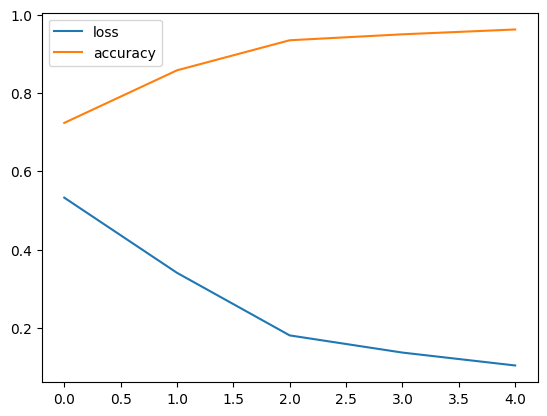

In [130]:
pd.DataFrame(history.history).plot()

In [131]:
model.save_weights("models/weights/sentiment_analysis_weights.h5")

In [136]:
def preprocess(X_batch):
    X_batch = tf.strings.substr(X_batch, 0, 300)
    X_batch = tf.strings.regex_replace(X_batch, rb"<br\s*/?>", b" ")
    X_batch = tf.strings.regex_replace(X_batch, b"[^a-zA-Z']", b" ")
    X_batch = tf.strings.split(X_batch)
    return X_batch.to_tensor(default_value=b"<pad>")

In [141]:
def encode_words(X_batch):
    return table.lookup(X_batch)

In [150]:
x_new = preprocess(["this movie was horrible"])
x_new = encode_words(x_new)

In [151]:
model.predict(x_new)

1/1 [==============================] - 0s 25ms/step


array([[0.09174055]], dtype=float32)

In [152]:
model(x_new)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.09174055]], dtype=float32)>

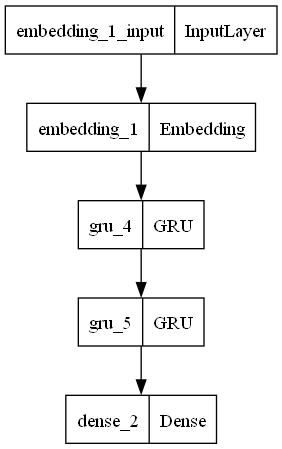

In [161]:
keras.utils.plot_model(model)

In [163]:
import tensorflow_hub as hub

In [164]:
model = Sequential()
model.add(hub.KerasLayer("https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1", dtype=tf.string, input_shape=[], output_shape=[50]))
model.add(Dense(128, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

In [167]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [168]:
datasets, info = tfds.load("imdb_reviews", as_supervised=True, with_info=True)
train_size = info.splits["train"].num_examples
batch_size = 32
train_set = datasets["train"].batch(batch_size).prefetch(1)

In [169]:
history = model.fit(train_set, epochs=5)

Epoch 1/5
782/782 [==============================] - 3s 3ms/step - loss: 0.5495 - accuracy: 0.7230
Epoch 2/5
782/782 [==============================] - 2s 3ms/step - loss: 0.5136 - accuracy: 0.7488
Epoch 3/5
782/782 [==============================] - 2s 3ms/step - loss: 0.5084 - accuracy: 0.7516
Epoch 4/5
782/782 [==============================] - 2s 3ms/step - loss: 0.5049 - accuracy: 0.7551
Epoch 5/5
782/782 [==============================] - 2s 3ms/step - loss: 0.5020 - accuracy: 0.7564


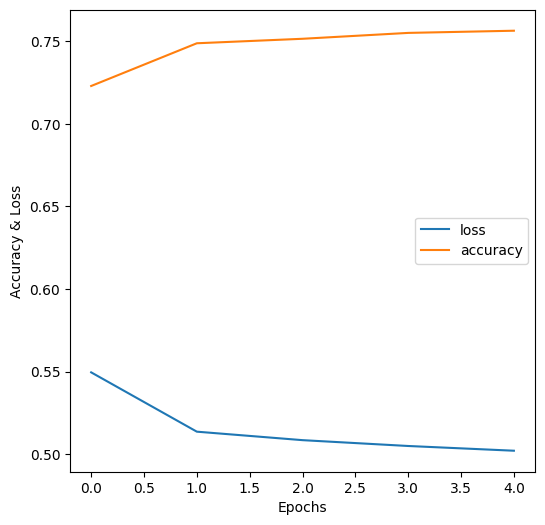

In [178]:
pd.DataFrame(history.history).plot(figsize=(6, 6))
plt.xlabel("Epochs")
plt.ylabel("Accuracy & Loss")
plt.show();

## Rede Codificador-Decodificador para Tradução Automática Neural

In [182]:
import tensorflow_addons as tfa

In [190]:
encoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
decoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
sequence_lengths = keras.layers.Input(shape=[], dtype=np.int32)

embeddings = keras.layers.Embedding(vocab_size, embed_size)
encoder_embeddings = embeddings(encoder_inputs)
decoder_embeddings = embeddings(decoder_inputs)

encoder = keras.layers.LSTM(512, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_embeddings)
encoder_state = [state_h, state_c]

sampler = tfa.seq2seq.sampler.TrainingSampler()

decoder_cell = keras.layers.LSTMCell(512)
output_layer = keras.layers.Dense(vocab_size)
decoder = tfa.seq2seq.basic_decoder.BasicDecoder(
    decoder_cell, sampler, output_layer=output_layer)
final_outputs, final_state, final_sequence_lengths = decoder(
    decoder_embeddings, initial_state=encoder_state, sequence_length=sequence_lengths)
Y_proba = tf.nn.softmax(final_outputs.rnn_output)

model = keras.Model(inputs=[encoder_inputs, decoder_inputs, sequence_lengths], outputs=[Y_proba])

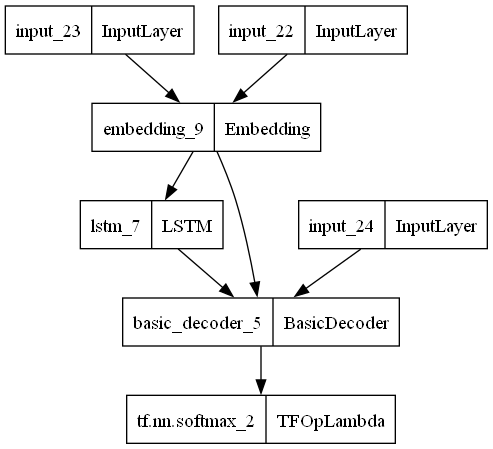

In [191]:
keras.utils.plot_model(model)

In [220]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")

In [221]:
X = np.random.randint(100, size=10*1000).reshape(1000, 10)
Y = np.random.randint(100, size=15*1000).reshape(1000, 15)
X_decoder = np.c_[np.zeros((1000, 1)), Y[:, :-1]]
seq_lengths = np.full([1000], 15)

In [222]:
pd.DataFrame(X)

,0,1,2,3,4,5,6,7,8,9
0,2,68,2,39,59,69,78,69,22,59
1,29,38,39,47,84,44,36,21,51,1
2,13,17,49,14,36,1,83,73,68,31
3,65,56,60,4,84,17,47,39,67,95
4,99,55,3,16,51,62,41,32,85,17
...,...,...,...,...,...,...,...,...,...,...
995,78,79,12,43,0,46,54,32,71,15
996,47,34,50,59,77,90,43,47,0,93
997,34,9,94,11,34,97,38,95,75,44
998,27,82,23,19,85,10,27,19,68,62


In [223]:
pd.DataFrame(Y)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,21,17,56,85,82,33,72,73,82,8,50,27,93,24,81
1,51,25,18,90,99,67,48,25,44,66,99,6,9,67,6
2,21,93,85,52,28,10,62,79,60,55,56,5,36,12,96
3,46,71,74,96,63,96,43,47,90,17,44,31,23,85,49
4,58,2,66,13,95,72,15,88,68,61,76,58,94,20,39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,77,96,67,52,91,41,29,17,8,6,99,52,78,90,4
996,42,68,85,86,12,69,46,44,97,1,8,21,89,19,73
997,84,59,10,20,81,65,52,99,92,21,79,23,65,94,25
998,70,35,36,17,26,93,73,94,79,18,57,35,32,60,5


In [226]:
history = model.fit([X, X_decoder, seq_lengths], Y, epochs=10)

Epoch 1/10
32/32 [==============================] - 8s 258ms/step - loss: 4.6645
Epoch 2/10
32/32 [==============================] - 9s 273ms/step - loss: 4.6326
Epoch 3/10
32/32 [==============================] - 9s 277ms/step - loss: 4.6192
Epoch 4/10
32/32 [==============================] - 9s 288ms/step - loss: 4.6130
Epoch 5/10
32/32 [==============================] - 9s 268ms/step - loss: 4.6087
Epoch 6/10
32/32 [==============================] - 9s 279ms/step - loss: 4.6038
Epoch 7/10
32/32 [==============================] - 9s 275ms/step - loss: 4.6008
Epoch 8/10
32/32 [==============================] - 9s 271ms/step - loss: 4.5966
Epoch 9/10
32/32 [==============================] - 9s 277ms/step - loss: 4.5953
Epoch 10/10
32/32 [==============================] - 8s 264ms/step - loss: 4.5922


<Axes: >

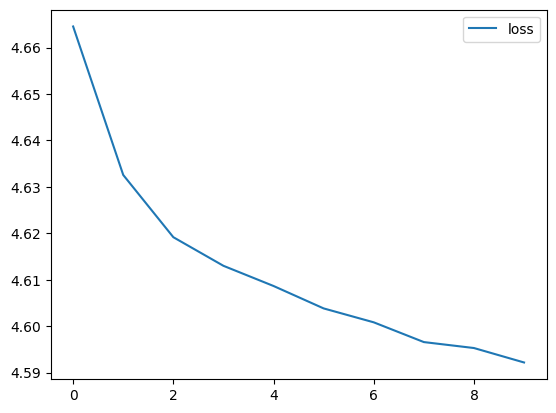

In [227]:
pd.DataFrame(history.history).plot()